In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from time import time

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

from scipy.stats import norm

import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 1
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

In [11]:
from WGAN import WGAN, WGAN_GP, VanillaGAN

In [12]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()

    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

# <center>Deep Generative Models</center>
## <center>Seminar 9</center>

<center><img src="pics/AIMastersLogo.png" width=600 /></center>
<center>10.04.2024</center>


## Plan

1. Wasserstein GANs
     
     - Vanilla GAN
     
     - WGAN
     
     - WGAN-GP
     
     - SNGAN

2. GANs zoo

3. Evolution of GANs

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

**Practical Note**:

Use **RMSProp** or **Adam** with $\beta_1 = 0$ when training your GAN. Large $\beta_1$ of Adam leads to training instabilities!

In [18]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

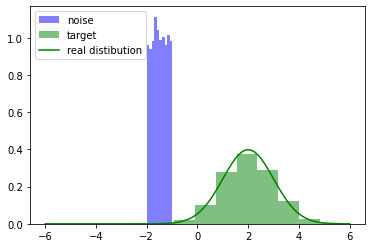

In [19]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [23]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')

In [24]:
epochs = 50
batches = 100

In [ ]:
step_size = 30
loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        #ldr_, ldf_ = gan.train_step_D()
        #if i%step_size == 0:
        #    print(i)
        #    print('D train step')
        #    visualize_GAN(gan)
        #lg_ = gan.train_step_G()
        #if i%step_size == 0:
        #    print('G train step')
        #    visualize_GAN(gan)
        
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

## WGAN

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x}, \boldsymbol{\phi})  - \mathbb{E}_{p(\mathbf{z})} f(G(\mathbf{z}, \boldsymbol{\theta}), \boldsymbol{\phi} )\right].
$$
Here $f(\mathbf{x}, \boldsymbol{\phi})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

<img src="pics/wgan_alg.jpg" width=800 height=800 />

In [46]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

In [74]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN(G, D, noise_fn, data_fn, device='cpu', n_critic=5, clip_c=0.01)

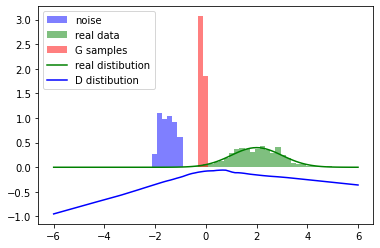

In [75]:
visualize_GAN(gan, data_pdf=data_pdf)

In [76]:
epochs = 50
batches = 100

In [ ]:
loss_g, loss_d_real, loss_d_fake, loss_WD = [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running = 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f},"
            f" WD={loss_WD[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)
    #break

In [87]:
params = []
for param in gan.D.parameters():
    params.extend(param.detach().numpy().flatten())

In [89]:
plt.hist(params, bins=100);

### Bimodal distribution

In [42]:
noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

pi = torch.tensor([0.7, 0.3])
mu = torch.tensor([-3., 3.])
scale = torch.tensor([1., 1.])

mixture_gaussian = TD.MixtureSameFamily(TD.Categorical(pi), TD.Normal(mu, scale))

def data_fn(x):
    return mixture_gaussian.sample((x, 1))

def data_pdf(x):
    return mixture_gaussian.log_prob(torch.tensor(x)).exp().numpy()

In [43]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN(G, D, noise_fn, data_fn, device='cpu', n_critic=5, clip_c=0.01)

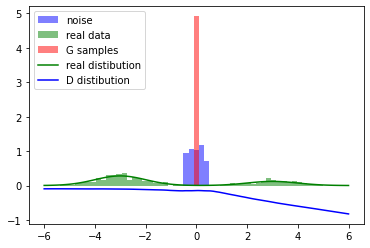

In [44]:
visualize_GAN(gan, data_pdf=data_pdf)

In [ ]:
loss_g, loss_d_real, loss_d_fake, loss_WD = [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running = 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f},"
            f" WD={loss_WD[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)
    #break

## WGAN-GP

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

<img src="pics/WGAN-GP_theorem.jpg" width=800 height=800 />

<img src="pics/wgan-gp_alg.jpg" width=800 height=800 />

In [78]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

In [83]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = get_simple_model(dis_hiddens)

gan = WGAN_GP(G, D, noise_fn, data_fn, device='cpu', n_critic=5, Lambda=1)

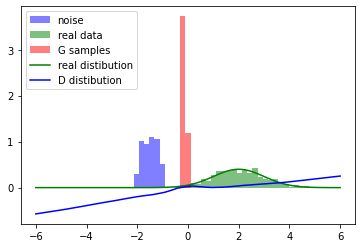

In [84]:
visualize_GAN(gan, data_pdf=data_pdf)

In [85]:
epochs = 50
batches = 100

Epoch 1/50 (0s): G=0.097, Dr=1.787, Df=0.101 WD=0.025, GP=0.298


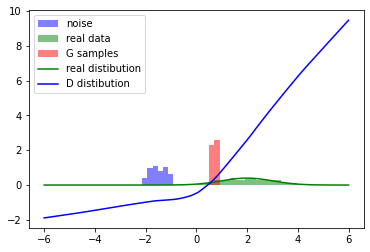

Epoch 2/50 (0s): G=0.507, Dr=2.100, Df=0.513 WD=0.007, GP=0.345


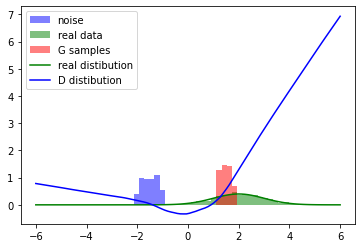

Epoch 3/50 (1s): G=0.595, Dr=0.961, Df=0.602 WD=-0.001, GP=0.132


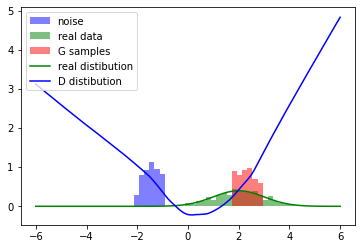

Epoch 4/50 (2s): G=0.153, Dr=-0.011, Df=0.162 WD=0.002, GP=0.258


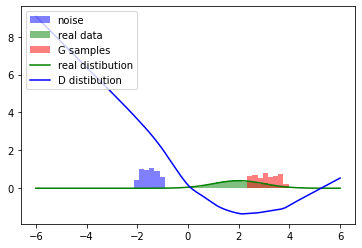

Epoch 5/50 (2s): G=-3.457, Dr=-2.553, Df=-3.434 WD=0.008, GP=0.435


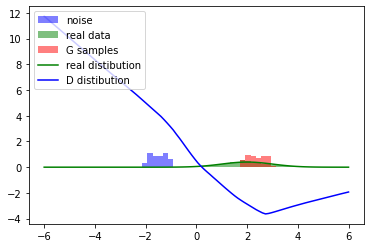

Epoch 6/50 (3s): G=-2.537, Dr=-1.737, Df=-2.543 WD=0.007, GP=0.149


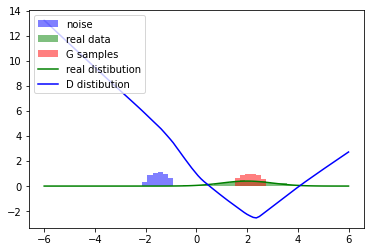

Epoch 7/50 (3s): G=-2.067, Dr=-1.305, Df=-2.072 WD=0.009, GP=0.147


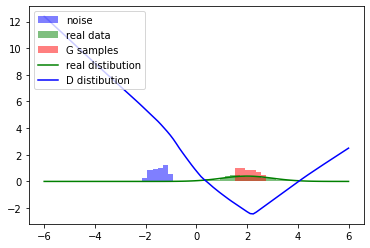

Epoch 8/50 (4s): G=-2.127, Dr=-1.433, Df=-2.131 WD=0.007, GP=0.107


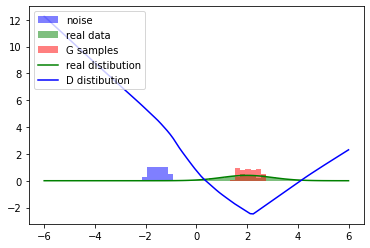

Epoch 9/50 (4s): G=-2.213, Dr=-1.518, Df=-2.210 WD=0.006, GP=0.104


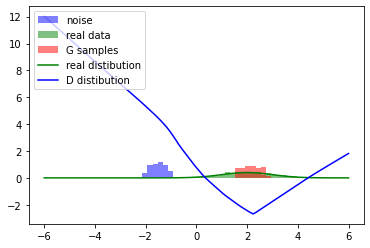

Epoch 10/50 (5s): G=-2.223, Dr=-1.568, Df=-2.224 WD=0.006, GP=0.101


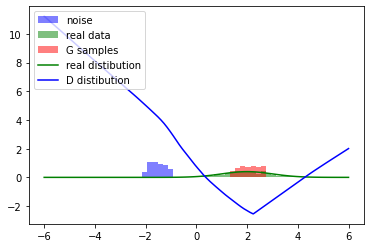

Epoch 11/50 (5s): G=-2.073, Dr=-1.438, Df=-2.073 WD=0.006, GP=0.094


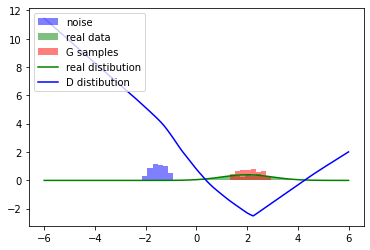

Epoch 12/50 (6s): G=-2.057, Dr=-1.462, Df=-2.054 WD=0.006, GP=0.085


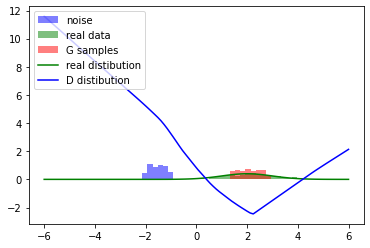

Epoch 13/50 (6s): G=-1.958, Dr=-1.405, Df=-1.957 WD=0.004, GP=0.082


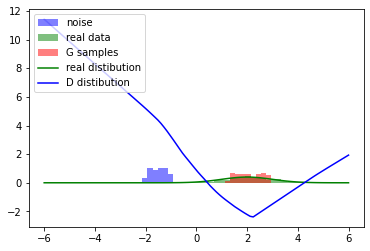

Epoch 14/50 (7s): G=-1.814, Dr=-1.290, Df=-1.813 WD=0.005, GP=0.083


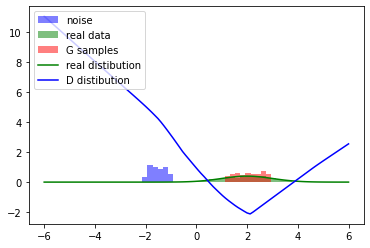

Epoch 15/50 (7s): G=-1.652, Dr=-1.181, Df=-1.655 WD=0.005, GP=0.100


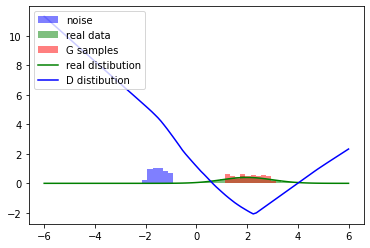

Epoch 16/50 (8s): G=-1.462, Dr=-1.047, Df=-1.450 WD=0.003, GP=0.065


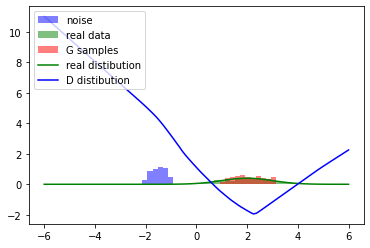

Epoch 17/50 (8s): G=-1.285, Dr=-0.932, Df=-1.278 WD=0.003, GP=0.091


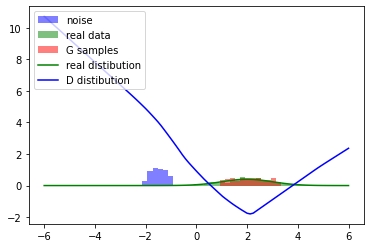

Epoch 18/50 (9s): G=-1.094, Dr=-0.830, Df=-1.095 WD=0.001, GP=0.077


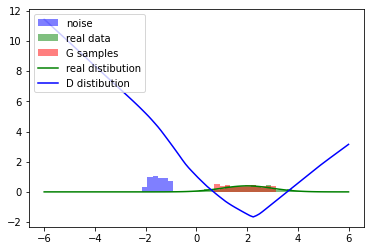

Epoch 19/50 (9s): G=-0.973, Dr=-0.795, Df=-0.977 WD=0.002, GP=0.089


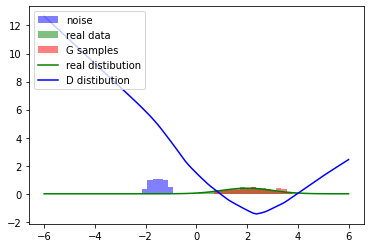

Epoch 20/50 (10s): G=-0.496, Dr=-0.375, Df=-0.501 WD=0.002, GP=0.112


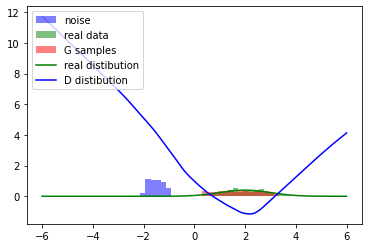

Epoch 21/50 (10s): G=-1.030, Dr=-1.019, Df=-1.029 WD=-0.002, GP=0.202


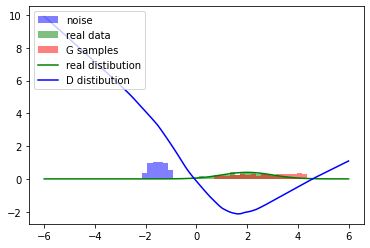

Epoch 22/50 (11s): G=-1.637, Dr=-1.604, Df=-1.638 WD=0.006, GP=0.318


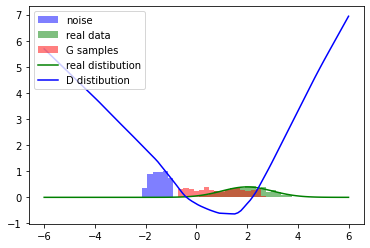

Epoch 23/50 (11s): G=-1.321, Dr=-1.132, Df=-1.283 WD=0.007, GP=0.326


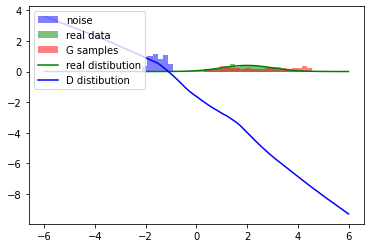

Epoch 24/50 (12s): G=-2.114, Dr=-2.417, Df=-2.131 WD=0.008, GP=0.318


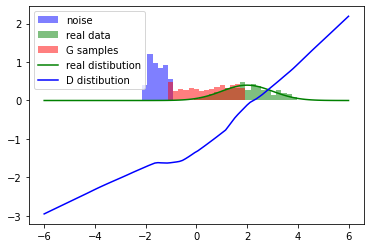

Epoch 25/50 (13s): G=0.388, Dr=0.598, Df=0.381 WD=-0.005, GP=0.149


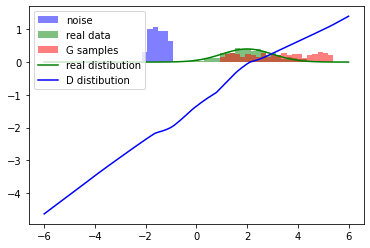

Epoch 26/50 (13s): G=-2.029, Dr=-1.697, Df=-1.966 WD=0.005, GP=0.412


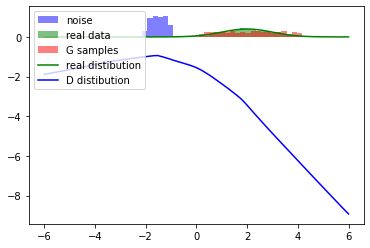

Epoch 27/50 (14s): G=-1.933, Dr=-2.344, Df=-1.937 WD=-0.005, GP=0.202


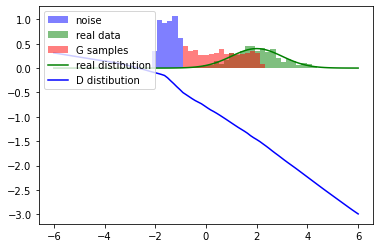

Epoch 28/50 (14s): G=0.015, Dr=0.343, Df=-0.029 WD=-0.002, GP=0.323


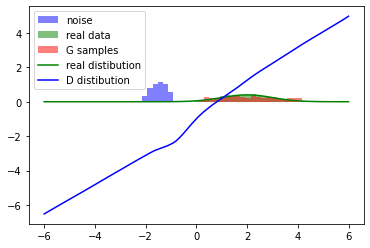

Epoch 29/50 (15s): G=0.954, Dr=0.522, Df=0.983 WD=-0.004, GP=0.236


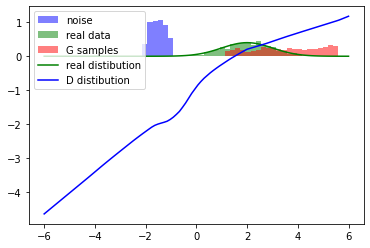

Epoch 30/50 (15s): G=-0.389, Dr=-0.379, Df=-0.328 WD=0.023, GP=0.613


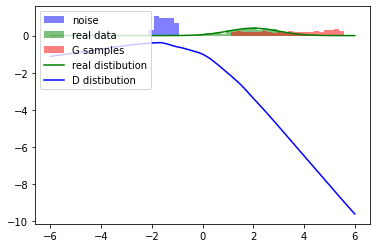

Epoch 31/50 (16s): G=-2.884, Dr=-2.624, Df=-2.878 WD=-0.005, GP=0.126


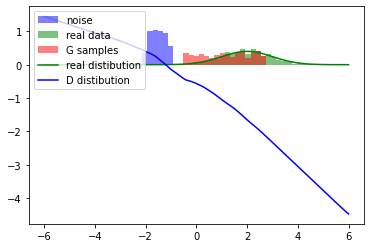

Epoch 32/50 (16s): G=-0.620, Dr=-1.053, Df=-0.620 WD=0.002, GP=0.426


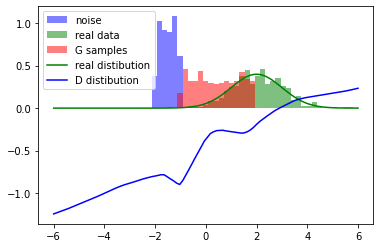

Epoch 33/50 (17s): G=1.262, Dr=1.762, Df=1.259 WD=-0.004, GP=0.121


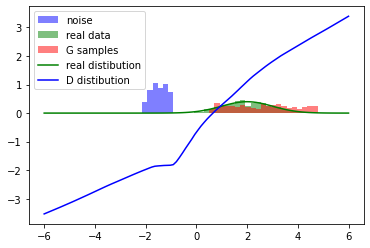

Epoch 34/50 (17s): G=1.140, Dr=0.702, Df=1.158 WD=-0.003, GP=0.354


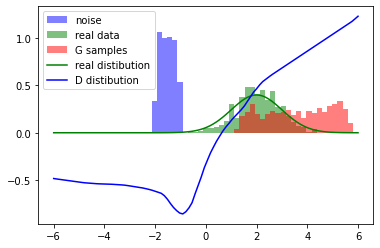

Epoch 35/50 (18s): G=0.261, Dr=0.163, Df=0.300 WD=0.020, GP=0.699


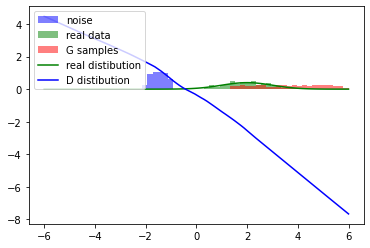

Epoch 36/50 (18s): G=-2.925, Dr=-2.364, Df=-2.936 WD=-0.004, GP=0.146


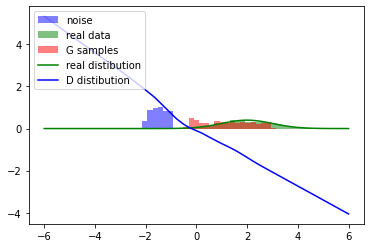

Epoch 37/50 (19s): G=-0.375, Dr=-0.805, Df=-0.369 WD=0.006, GP=0.351


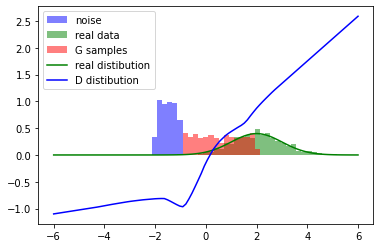

Epoch 38/50 (19s): G=1.780, Dr=2.238, Df=1.773 WD=-0.005, GP=0.114


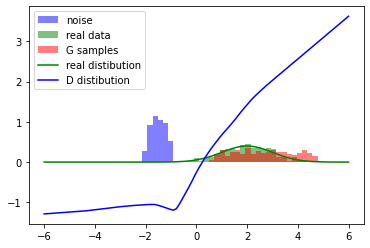

Epoch 39/50 (20s): G=1.462, Dr=0.992, Df=1.464 WD=-0.004, GP=0.342


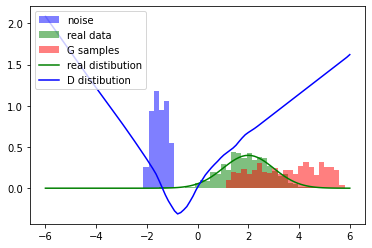

Epoch 40/50 (20s): G=-1.111, Dr=-0.654, Df=-1.077 WD=0.012, GP=0.590


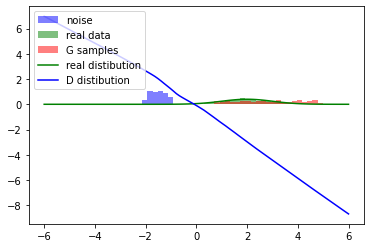

Epoch 41/50 (21s): G=-1.945, Dr=-2.040, Df=-1.976 WD=-0.004, GP=0.082


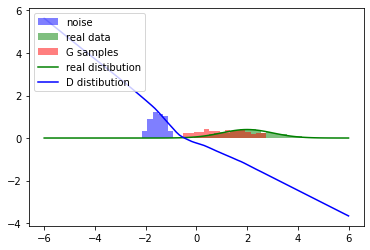

Epoch 42/50 (22s): G=-0.266, Dr=-0.709, Df=-0.268 WD=-0.003, GP=0.425


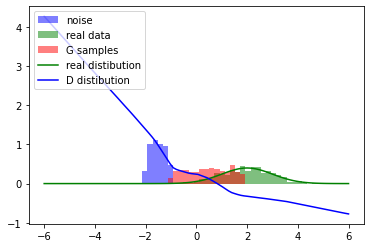

Epoch 43/50 (22s): G=1.579, Dr=2.325, Df=1.566 WD=-0.004, GP=0.266


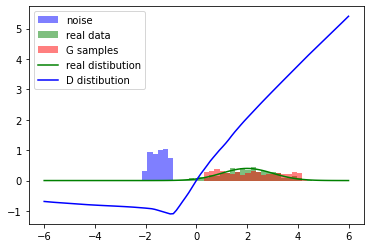

Epoch 44/50 (23s): G=1.802, Dr=1.366, Df=1.818 WD=-0.004, GP=0.206


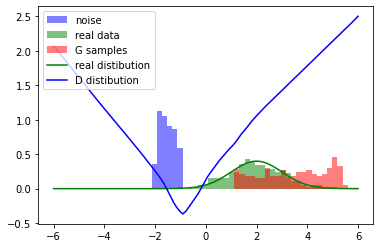

Epoch 45/50 (23s): G=-0.285, Dr=-0.077, Df=-0.242 WD=0.019, GP=0.550


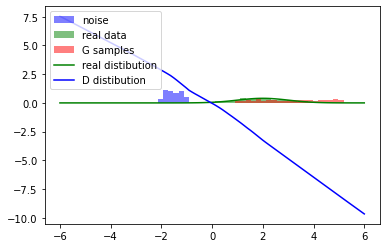

Epoch 46/50 (24s): G=-2.298, Dr=-2.161, Df=-2.306 WD=-0.005, GP=0.093


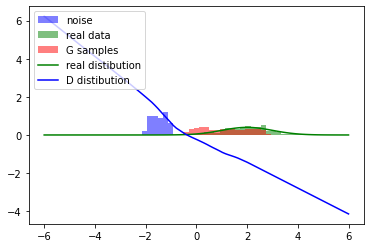

Epoch 47/50 (24s): G=-0.345, Dr=-0.829, Df=-0.361 WD=-0.003, GP=0.364


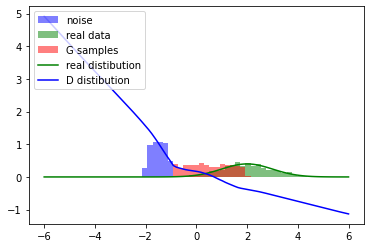

Epoch 48/50 (25s): G=0.883, Dr=1.533, Df=0.881 WD=0.008, GP=0.462


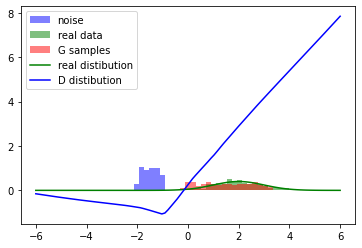

Epoch 49/50 (25s): G=2.075, Dr=1.850, Df=2.086 WD=-0.005, GP=0.090


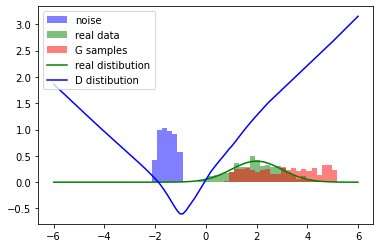

Epoch 50/50 (26s): G=1.249, Dr=0.855, Df=1.266 WD=-0.000, GP=0.474


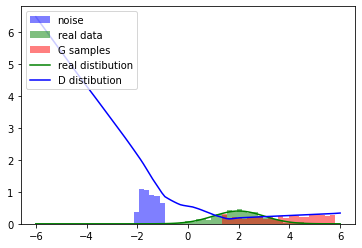

In [86]:
step_size = 30
loss_g, loss_d_real, loss_d_fake, loss_WD, loss_gp = [], [], [], [], []
start = time()
for epoch in range(epochs):
    #break
    loss_g_running, loss_d_real_running, loss_d_fake_running, loss_WD_running, loss_gp_running = 0, 0, 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_, lgp_) = gan.train_step()
        #ldr_, ldf_ = gan.train_step_D()
        #if i%step_size == 0:
        #    print(i)
        #    print('D train step')
        #    visualize_GAN(gan)
        #lg_ = gan.train_step_G()
        #if i%step_size == 0:
        #    print('G train step')
        #    visualize_GAN(gan)
        
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
        loss_gp_running += lgp_
        loss_WD_running = ldr_ - ldf_
        
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    loss_gp.append(loss_gp_running / batches)
    loss_WD.append(loss_WD_running / batches)
    
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}"
          f" WD={loss_WD[-1]:.3f},"
          f" GP={loss_gp[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)
    #break

### SNGAN

Spectral Normalization GAN [article](https://arxiv.org/pdf/1802.05957.pdf) replaces the weights in the critic $f(\mathbf{x}, \boldsymbol{\phi})$ by 
$$
    \mathbf{W}^{SN} = \frac{\mathbf{W}}{\|\mathbf{W}\|_2}.
$$

This ensures that $\| f\|_L \leq 1.$.

Power iteration method allows to efficiently compute $\| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})}$.
    
The pseudocode of the method is:
* $\mathbf{u}_0$ -- random vector.
* for $k = 0, \dots, n - 1$: 
$$
    \mathbf{v}_{k+1} = \frac{\mathbf{W}^T \mathbf{u}_{k}}{\| \mathbf{W}^T \mathbf{u}_{k} \|}, \quad \mathbf{u}_{k+1} = \frac{\mathbf{W} \mathbf{v}_{k+1}}{\| \mathbf{W} \mathbf{v}_{k+1} \|}.
$$
* approximate the spectral norm
$$
    \| \mathbf{W} \|_2 = \sqrt{\lambda_{\text{max}}(\mathbf{W}^T \mathbf{W})} \approx \mathbf{u}_{n}^T \mathbf{W} \mathbf{v}_{n}.
$$


## GANs zoo

### Losses

- Vanilla GAN

    <img src="pics/gan_objective.jpg" width=800 height=800 />

    - Nonsaturating Vanilla GAN

- Wassersteing GAN 

    <img src="pics/WGAN_obj.jpg" width=800 height=800 />
    
    - WGAN-GP

- IPM GAN 

    **IPM** (Integral Probability Metric):
    
    $$
    \gamma_{\mathcal{F}}(\mathbb{P}, \mathbb{Q}) = \sup\limits_{f \in \mathcal{F}} \left\vert \int f d \mathbb{P} - \int f d \mathbb{Q} \right\vert,
    $$ 
    see [Sriperumbudur et. al.](https://arxiv.org/pdf/0901.2698.pdf) for the details on IPM metric.
    
    see [Mroueh et. al.](https://arxiv.org/pdf/1711.04894.pdf) for the examples of IPM GANs.
    
    
- GAN with Hinge loss

    <img src="pics/hinge_loss_GAN.png" width=800 height=800 />
    
    see [Lim et. al.](https://arxiv.org/pdf/1705.02894.pdf)

- fGAN 

    <img src="pics/fgan_loss.png" width=800 height=800 />
    
    article: [Nowozin et. al.](https://arxiv.org/pdf/1606.00709.pdf)
    
    * **Question:** By which parameter we maximize, and by which we minimize?
    
- ...

### Regularizations

- Weight clipping, Gradient penalty in WGAN

- Spectral Normalization (for general GAN architectures)

- $R_1$, $R_2$, $R_3$ regularizations (penalize discriminator gradients) [paper](https://arxiv.org/pdf/1801.04406.pdf), [paper2](https://arxiv.org/pdf/1705.09367.pdf)

- Improved techniques for training GANs [paper](https://arxiv.org/pdf/1606.03498.pdf)

- Orthogonal regularization [paper](https://arxiv.org/pdf/1809.11096.pdf)

    <img src="pics/ortho_reg.png" width=400 height=800 />

- ...